In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib

In [2]:
data = pd.read_csv('News.csv',index_col=0)
data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [3]:
data.shape

(44919, 5)

In [4]:
data = data.drop(["title", "subject","date"], axis = 1)

In [5]:
data.isnull().sum()

text     0
class    0
dtype: int64

In [6]:
# Shuffling
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)

<Axes: xlabel='class', ylabel='count'>

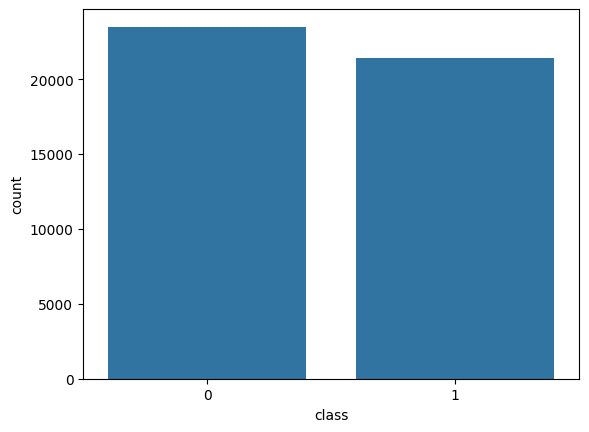

In [7]:
sns.countplot(data=data,
			x='class',
			order=data['class'].value_counts().index)

In [8]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def preprocess_text(text_data):
	preprocessed_text = []

	for sentence in tqdm(text_data):
		sentence = re.sub(r'[^\w\s]', '', sentence)
		preprocessed_text.append(' '.join(token.lower()
								for token in str(sentence).split()
								if token not in stopwords.words('english')))

	return preprocessed_text

In [10]:
if os.path.exists('preprocessed_data.csv'):
    print("Preprocessed data found. Loading...")
    data = pd.read_csv('preprocessed_data.csv')
else:
    print("Preprocessed data not found. Running preprocessing...")
    
    # Clean data: remove missing values and empty strings
    print(f"Original data shape: {data.shape}")
    print(f"Missing values in text column: {data['text'].isna().sum()}")
    
    # Remove rows with missing text
    data = data.dropna(subset=['text'])
    data = data[data['text'].str.strip() != '']
    print(f"Data shape after removing missing values: {data.shape}")
    
    # ---- Preprocess text data ----
    preprocessed_review = preprocess_text(data['text'].values)
    data['text'] = preprocessed_review
    
    # ---- Save preprocessed data ----
    data.to_csv('preprocessed_data.csv', index=False)
    print("Preprocessed data saved as 'preprocessed_data.csv'")

# Additional check to ensure no missing values remain
print(f"Final data shape: {data.shape}")
print(f"Missing values after preprocessing: {data.isna().sum().sum()}")
print(f"Empty strings in text column: {(data['text'] == '').sum()}")

Preprocessed data found. Loading...
Final data shape: (44919, 2)
Missing values after preprocessing: 631
Empty strings in text column: 0


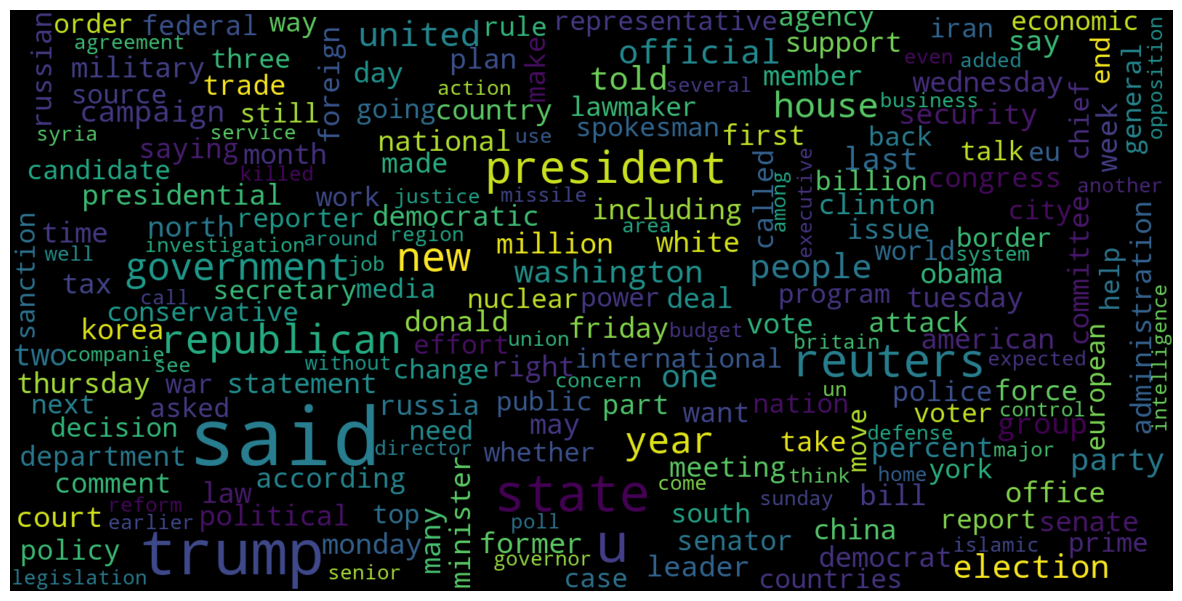

In [11]:
# Real
consolidated = ' '.join(
	word for word in data['text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

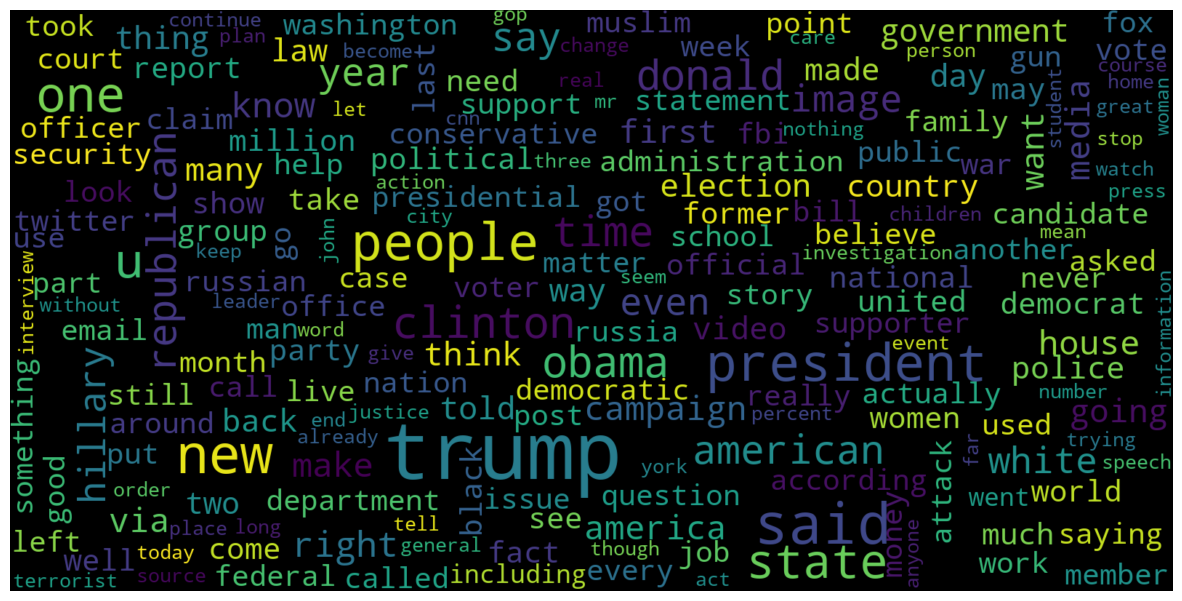

In [12]:
# Fake
consolidated = ' '.join(
	word for word in data['text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

Checking for missing values in text data...
Number of NaN values in text column: 631
Number of empty strings in text column: 0
Data shape after cleaning: (44288, 2)


<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

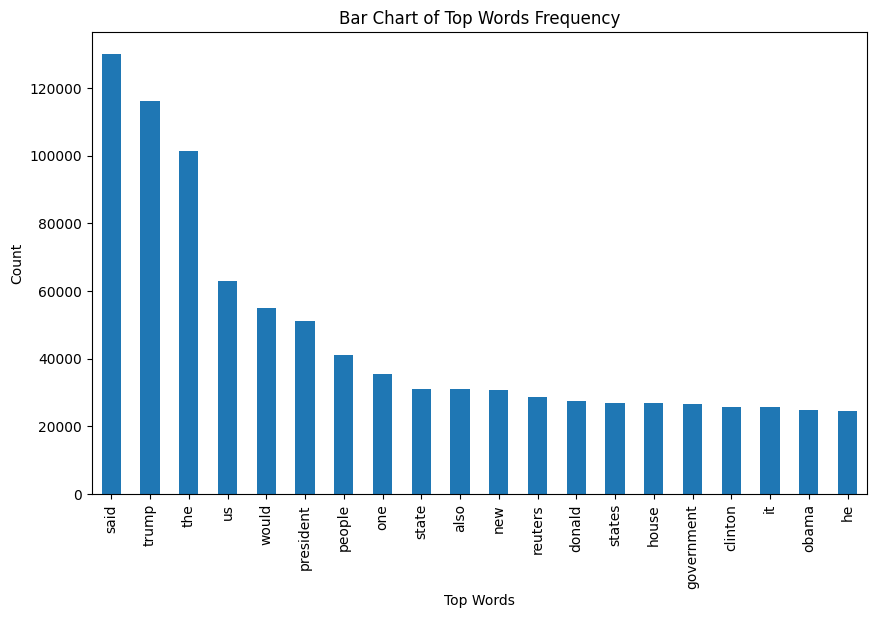

In [13]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
	# Clean the corpus by removing NaN values and converting to string
	clean_corpus = [str(doc) for doc in corpus if pd.notna(doc) and str(doc).strip() != '']
	
	if not clean_corpus:
		print("Warning: No valid documents found after cleaning.")
		return []
	
	vec = CountVectorizer().fit(clean_corpus)
	bag_of_words = vec.transform(clean_corpus)
	sum_words = bag_of_words.sum(axis=0)
	words_freq = [(word, sum_words[0, idx])
				for word, idx in vec.vocabulary_.items()]
	words_freq = sorted(words_freq, key=lambda x: x[1],
						reverse=True)
	return words_freq[:n]


# Clean the data before processing
print("Checking for missing values in text data...")
print(f"Number of NaN values in text column: {data['text'].isna().sum()}")
print(f"Number of empty strings in text column: {(data['text'] == '').sum()}")

# Remove rows with missing or empty text
data_clean = data.dropna(subset=['text'])
data_clean = data_clean[data_clean['text'].str.strip() != '']
print(f"Data shape after cleaning: {data_clean.shape}")

common_words = get_top_n_words(data_clean['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
	kind='bar',
	figsize=(10, 6),
	xlabel="Top Words",
	ylabel="Count",
	title="Bar Chart of Top Words Frequency"
)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Ensure we're using clean data for machine learning
print("Preparing data for machine learning...")
print(f"Original data shape: {data.shape}")

# Clean the data: remove NaN values and empty strings
data_clean = data.dropna(subset=['text', 'class'])
data_clean = data_clean[data_clean['text'].str.strip() != '']
print(f"Clean data shape: {data_clean.shape}")

# Check for any remaining issues
print(f"Remaining NaN values in text: {data_clean['text'].isna().sum()}")
print(f"Remaining NaN values in class: {data_clean['class'].isna().sum()}")
print(f"Empty text entries: {(data_clean['text'].str.strip() == '').sum()}")

# Convert to string to ensure no data type issues
data_clean['text'] = data_clean['text'].astype(str)

x_train, x_test, y_train, y_test = train_test_split(data_clean['text'],
													data_clean['class'],
													test_size=0.25,
													random_state=42)

print(f"Training set size: {len(x_train)}")
print(f"Test set size: {len(x_test)}")
print("Data split completed successfully!")

Preparing data for machine learning...
Original data shape: (44919, 2)
Clean data shape: (44288, 2)
Remaining NaN values in text: 0
Remaining NaN values in class: 0
Empty text entries: 0
Training set size: 33216
Test set size: 11072
Data split completed successfully!


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Additional data validation before vectorization
print("Validating training and test data...")
print(f"x_train type: {type(x_train)}")
print(f"x_train shape: {x_train.shape}")
print(f"Number of NaN in x_train: {x_train.isna().sum()}")
print(f"Number of NaN in x_test: {x_test.isna().sum()}")

# Convert to list and clean any remaining issues
x_train_clean = [str(doc) for doc in x_train if pd.notna(doc) and str(doc).strip() != '']
x_test_clean = [str(doc) for doc in x_test if pd.notna(doc) and str(doc).strip() != '']

print(f"Clean training samples: {len(x_train_clean)}")
print(f"Clean test samples: {len(x_test_clean)}")

# Initialize and fit the vectorizer
vectorization = TfidfVectorizer(max_features=5000, lowercase=True, stop_words='english')
x_train = vectorization.fit_transform(x_train_clean)
x_test = vectorization.transform(x_test_clean)

print(f"TF-IDF training matrix shape: {x_train.shape}")
print(f"TF-IDF test matrix shape: {x_test.shape}")
print("TF-IDF vectorization completed successfully!")

Validating training and test data...
x_train type: <class 'pandas.core.series.Series'>
x_train shape: (33216,)
Number of NaN in x_train: 0
Number of NaN in x_test: 0
Clean training samples: 33216
Clean test samples: 11072
TF-IDF training matrix shape: (33216, 5000)
TF-IDF test matrix shape: (11072, 5000)
TF-IDF vectorization completed successfully!


In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9922326589595376
0.9878070809248555


In [17]:
joblib.dump(model, 'model_files/fake_news_logistic_model.pkl')
print("Model saved as 'fake_news_logistic_model.pkl'")

Model saved as 'fake_news_logistic_model.pkl'


In [18]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

1.0
0.995032514450867


In [19]:
joblib.dump(model, 'model_files/fake_news_tree_model.pkl')
print("Model saved as 'fake_news_tree_model.pkl'")

Model saved as 'fake_news_tree_model.pkl'


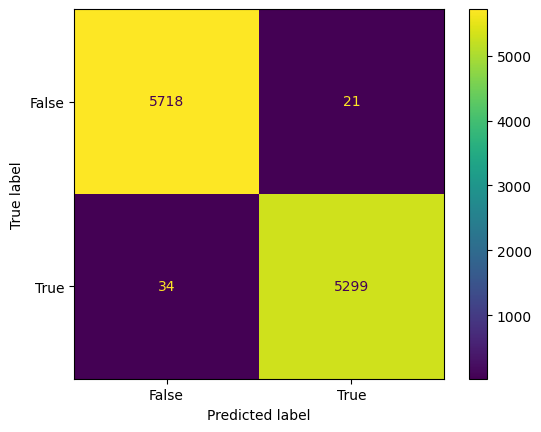

In [20]:
# Confusion matrix of Results from Decision Tree classification
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
											display_labels=[False, True])

cm_display.plot()
plt.show()